# This notebook has following goals:

- Get difference between old and new wiki page
- Cleaning (lower cases, removing stopwords)

# 0. Import libraries

In [8]:
# data manipulation

from difflib import unified_diff
import difflib
import pandas as pd
import re
import string
import nltk
import itertools

# visualize
import matplotlib.pyplot as plt
import seaborn as sns

# pyspark

from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from pyspark.sql.functions import udf, struct, array, col, lit, regexp_replace, lower
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.types import IntegerType, StringType
from pyspark.streaming import StreamingContext

# other
from threading import Thread
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

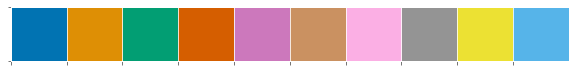

In [9]:
# global variables (use capital letter for variables)

plt.style.use('ggplot')
current_palette = sns.color_palette("colorblind")
sns.palplot(current_palette)
sns.set_palette("colorblind")
DPI = 500 # determines quality when saving figures

# 1. Get streaming instances
This section is only for the purpose to set up and do intermediate checks of the pipeline with live data.

In [10]:
# This only serves as trial to test my functions on live incoming instances
class StreamingThread(Thread):
    def __init__(self, ssc):
        Thread.__init__(self)
        self.ssc = ssc
    # Start stream
    def run(self):
        ssc.start()
        ssc.awaitTermination()
    # Stop stream
    def stop(self):
        print('----- Stopping... this may take a few seconds -----')
        self.ssc.stop(stopSparkContext=False, stopGraceFully=True)

# ssc = StreamingContext(sc, 10) # Every 10 seconds, construct a mini-batch of RDDs
# lines = ssc.socketTextStream("seppe.net", 7778)
# lines.pprint()
# ssc_t = StreamingThread(ssc)
# ssc_t.start()

In [11]:
# ssc_t.stop()

# 2. Helper functions

In [12]:
# Get Spark dataframe --> various sites state that a dataframe is better than a DDR for textual data

def get_wiki_df(path = "../../data/*"):
    
    """ reads in the data
    Args
        path (str): the path can be either a single text file or a directory storing text files. 
    Returns
        (pyspark.sql.dataframe.DataFrame) textual data
    """

    wiki_df = spark.read.json(path)

    # Uncomment if you want its schema
    # wiki_df.printSchema()
    return wiki_df

In [13]:
def get_label_count(wiki_df):
    
    """
    For this function you should only pass the full 
    wiki_df in order to get the label count.
    --------------------------------------
    Last result (so you don't need to run it each time) 
    -> safe: 30333, unsafe: 4136, vandal: 270
    """
    # Creates a temporary view using the wiki DataFrame
    wiki_df.createOrReplaceTempView("wikidata")                            
                                                                                  
    # Check the amount of safes/unsafes/vandals                                    
    label_df = spark.sql("SELECT label, count(*) FROM wikidata GROUP BY label")    
    return label_df                                                       

In [16]:
def show_X_rows(df, x): 
    
    """ 
    Shows first X number of spark dataframe rows
    Input the dataframe followed by a 
    number in order to see the first x amount
    of rows
    
    """
    
    # Convert list to RDD
    rdd = spark.sparkContext.parallelize(df.take(x))

    # Create data frame
    df_temp = spark.createDataFrame(rdd)
    return df_temp.show()

def flatten(nested_list):
    
    """
    Function that flattens a nested list.
    
    """
    
    flat_list = []
    for sublist in nested_list:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
        else:
            flat_list.append(sublist)
            
    return flat_list

## 2.1 Function to get the difference between old and new text

In [ ]:
# Get edited part of wiki page (credits to the professor)
def get_diff_1(old, new):
    
    """"
    Takes in old and new columns and 
    returns the difference between the two
    """
    
    return '\n'.join([ l for l in unified_diff(old.split('\n'), new.split('\n')) if l.startswith('+') or l.startswith('-') ])

# The difference function that will take a very long time to compute for all instances
def get_diff_2(old, new):
    
    """
    Takes in old and new columns and 
    returns the difference between the two
    
    """
    
    deleted_words = []
    added_words = []
    temp_i = -100
    new_word = ''
    status = 'none'
    for i, s in enumerate(difflib.ndiff(old, new)):
        if s[0] == ' ':
            if status == 'adding':
                added_words.append(new_word)
                new_word = ''
            elif status == 'deleting':
                deleted_words.append(new_word)
                new_word = ''
            status = 'none'
            continue
        elif s[0] == '-':
            if status != 'deleting':
                added_words.append(new_word)
                new_word = ''
                status = 'deleting'
            new_word += s[-1]
        elif s[0] == '+':
            if status != 'adding':
                deleted_words.append(new_word)
                new_word = ''
                status = 'adding'
            new_word += s[-1]
    if new_word != '' and status == 'deleting':
        deleted_words.append(new_word)
    elif new_word != '' and status == 'adding':
        added_words.append(new_word)
    return {'added': added_words, 'deleted': deleted_words}

def get_deletions(del_add):
    
    """
    Function that returns the deleted
    words out of a list of deleted and added
    words
    """

    
    return del_add['deleted']

def get_additions(del_add):
    
    """"
    Function that returns the added
    words out of a list of deleted and added
    words
    
    """
    
    return del_add['added']

def extract_differences(str_old, str_new):
    
    """
    Function that splits old and new string
    and extracts its differences
    
    """
    
    try:
        # Clean old and new wiki pages from html characters
        str_old, str_new = cleanhtml(str_old), cleanhtml(str_new)

        # Get big chunks of altered fragments
        diff1 = get_diff_1(str_old, str_new)


        # Clean the differences from unwanted characters to get only words
        diff2 = []
        for txt in diff1.split('\n'):
            diff2.append(''.join([x for x in txt if x in string.ascii_letters + '\'-+ 1234567890']).lower())

        # Find chunks that are related ('+' vs '-') else append them to a seperate list that doesn't need to get processed in the next part
        fully_added, fully_removed, partly_new, partly_old = find_similar_chunks(diff2)

        # Get the individual fragments that were added or deleted
        for i in range(0,len(partly_new)):
            difference = get_diff_2(partly_new[i], partly_old[i])
            for el in difference['added']:
                fully_added.append(el)
            for el in difference['deleted']:
                fully_removed.append(el)

        fully_removed = flatten(fully_removed)
        fully_added = flatten(fully_added)
        while '' in fully_added:
            fully_added.remove('')
        while '+' in fully_added:
            fully_added.remove('+')
        while '-' in fully_added:
            fully_added.remove('-')

        while '' in fully_removed:
            fully_removed.remove('')
        while '+' in fully_removed:
            fully_removed.remove('+')
        while '-' in fully_removed:
            fully_removed.remove('-')

        # Original output_lib was a dictionary
        #output_lib = {'added': fully_added, 'removed': fully_removed}

        output_str = ''
        # However, now we'd like to have the output in a list with seperator "|SEPERATIONLINEADDEDREMOVED|"
        for word in fully_added:
            output_str += '{} '.format(word)

        output_str += ' |SEPERATIONLINEADDEDREMOVED|'

        for word in fully_removed:
            output_str += ' {}'.format(word)

        full_difference = []

        return output_str
    except:
        return 'error_would_occur'

def find_similar_chunks(chunk_list):
    
    """
    Function that takes in the differences between two blocks of
    text and returns the exact deletion and added chunks
    Not important to understand this function, it was a means 
    to process the output from get_diff_1 in order to process 
    further, it speeds up the process
    
    """
    
    fully_added, fully_removed, partly_removed, partly_added = [], [], [], []
    # Remove '', ---, +++
    while '' in chunk_list:
        chunk_list.remove('')
    while '+++ ' in chunk_list:
        chunk_list.remove('+++ ')
    while '--- ' in chunk_list:
        chunk_list.remove('--- ')
    for chunk in chunk_list:
        try:
            if chunk[3] not in string.ascii_letters + '\'-+ 1234567890':
                chunk_list.remove(chunk)
            else:
                continue
        except:
            chunk_list.remove(chunk)

    for a, b in itertools.combinations(chunk_list, 2):
        if a[1:30] == b[1:30]:
            if a[0] == '+':
                partly_added.append(a)
                partly_removed.append(b)
                chunk_list.remove(a)
                chunk_list.remove(b)
            else:
                partly_added.append(b)
                partly_removed.append(a)
                chunk_list.remove(a)
                chunk_list.remove(b)
    for rest in chunk_list:
        if rest[0] == '-':
            fully_removed.append(rest[1:].split(' '))
        elif rest[0] == '+':
            fully_added.append(rest[1:].split(' '))
    return fully_added, fully_removed, partly_removed, partly_added

## 2.2 Clean columns: *comments, title, user, text_old, text_new*

In [ ]:

def cleanhtml(raw_html):
    
    """
    Clean a raw text part from html symbols and words
    """
    
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw_html)
    
    # Remove urls
    cleantext_no_urls = re.sub(r"http\S+", "", cleantext)
    return cleantext_no_urls

def cleantext(raw):
    
    """
    Clean a raw text part further from other unimportant characters
    and make it lower case
    """


    # If there's nothing in raw, return 'EMPTY'
    for item in 'azertyuiopmlkjhgfdsqnbvcxw,;:=ùµ$^)àç!è§(é&1234567890\"\')|@#]}{[^-_':
        if item in raw:
    
            cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
            cleantext = re.sub(cleanr, '', raw)

            # Remove urls
            cleantext_no_urls = re.sub(r"http\S+", "", cleantext)
            return ''.join([x for x in cleantext_no_urls if x in string.ascii_letters + '\'-+ 1234567890']).lower()
    return 'empty'

def get_clean_df(df):
    
    """
    Function used to pass the dataframe and clean its
    columns 
    """

    # Remove url_page column
    df_without_url = df.drop('url_page')

    # Cleaning comment, title_page and name_user
    clean_udf = udf(cleantext, StringType())
    df_without_url = df_without_url.withColumn('clean_comment', clean_udf(df_without_url.comment)).drop('comment')
    df_without_url = df_without_url.withColumn('clean_title_page', clean_udf(df_without_url.title_page)).drop('title_page')
    df_without_url = df_without_url.withColumn('clean_name_user', clean_udf(df_without_url.name_user)).drop('name_user')
    
    # Clean the old and new text columns
    df_without_url = df_without_url.withColumn('clean_old_text', clean_udf(df_without_url.text_old))
    df_without_url = df_without_url.withColumn('clean_new_text', clean_udf(df_without_url.text_new))
    
    data = df_without_url.select(col("label"), col("clean_comment").alias("comment"), col("clean_title_page").alias("title_page"), col("clean_name_user").alias("name_user"), col("text_old"), col("text_new"), col("clean_old_text"), col("clean_new_text"))
    return data

def get_difference_column(df):
    
    """
    Function that takes in the dataframe and returns
    a dataframe with an extra 'difference' column
    Drops the text_old and text_new columns
    
    """

    difference_udf = udf(extract_differences, StringType())
    intermediate_col = df.withColumn('difference', difference_udf(df.text_old, df.text_new))
    intermediate_col = intermediate_col.drop('text_old')
    intermediate_col = intermediate_col.drop('text_new')
    return intermediate_col

def paste_words(list_of_words):
    
    """
    Function that pastes together a list of words
    """
  
    return ' '.join([x for x in list_of_words])

## 2.3 Split *difference column* into added and removed column

In [ ]:

def get_removed_col(col):
    
    """
    Function that splits the 'difference' column and
    returns the removed words
    """
    
    for item in 'azertyuiopmlkjhgfdsqnbvcxw,;:=ùµ$^)àç!è§(é&1234567890\"\')|@#]}{[^-_':
            if item in col[:col.find('|SEPERATIONLINEADDEDREMOVED|')]:
                return col[:col.find('|SEPERATIONLINEADDEDREMOVED|')].split(' ')
    return ['empty']

def get_added_col(col):
    
    """
    Function that splits the 'difference' column and
    returns the added words
    """

    for item in 'azertyuiopmlkjhgfdsqnbvcxw,;:=ùµ$^)àç!è§(é&1234567890\"\')|@#]}{[^-_':
            if item in col[col.find('|SEPERATIONLINEADDEDREMOVED|') + len('|SEPERATIONLINEADDEDREMOVED|') + 1:]:
                return col[col.find('|SEPERATIONLINEADDEDREMOVED|') + len('|SEPERATIONLINEADDEDREMOVED|') + 1:].split(' ')
    return ['empty']


def split_difference_into_removed_added(df):
    
    """
    Function that splits the difference column and adds
    2 new columns: added_words and removed_words
    """

    get_removed_udf = udf(get_removed_col, types.ArrayType(types.StringType()).simpleString())
    df = df.withColumn('removed_words', get_removed_udf(df.difference))
    
    get_added_udf = udf(get_added_col, types.ArrayType(types.StringType()).simpleString())
    df = df.withColumn('added_words', get_added_udf(df.difference))
    
    df = df.drop('difference')
    
    return df

# 3. Preprocessing

## Import data and look at class distribution

In [ ]:
# Get the data as spark dataframe
wiki_df = get_wiki_df(path="../data/subset/*")

Label distribution when using all data: 
  - safe: 30333
  - unsafe: 4136
  - vandal: 270

In [ ]:
class_dist = get_label_count(wiki_df)
plt.figure(figsize=(8,4))
ax = class_dist.select("*").toPandas().plot.bar(x='label', y='count(1)', rot=0, legend=False)
ax.set_xlabel("Classes")
ax.set_ylabel("Count")
# save figure
plt.savefig('../output/figures/fig1.png', dpi=DPI)

In [ ]:
# Get clean dataframe (cleaning of comment, title_page, name_user):
clean_df = get_clean_df(wiki_df)

# In order to get the actual difference column
df_with_difference = get_difference_column(clean_df)

# Example of a difference column of the first of 20 instances:
# difference column is in the form REMOVED PART |SEPERATIONLINEADDEDREMOVED| ADDED PART
df_with_difference.show(5)

In [ ]:
# 2 columns: removed and added with space in new function. + Clean text_old and text_new
# Split difference column into column 'removed' and column 'added'

final_df = split_difference_into_removed_added(df_with_difference)
final_df.show(10)
final_df.count()